In [ ]:
import pandas as pd
import os

WIKI_R1000 = "https://en.wikipedia.org/wiki/Russell_1000_Index"

def _load_r1k() -> pd.DataFrame:
    # Load Russell 1000 table from Wikipedia
    for df in pd.read_html(WIKI_R1000):
        cols = {c.lower() for c in df.columns.astype(str)}
        if ("symbol" in cols or "ticker" in cols) and "gics sector" in cols:
            df = df.rename(columns={"Ticker": "Symbol"})
            keep = [c for c in ["Company", "Symbol", "GICS Sector", "GICS Sub-Industry"] if c in df.columns]
            out = df[keep].copy()
            out["Symbol"] = out["Symbol"].astype(str).str.strip().str.upper()
            return out
    raise RuntimeError("Russell 1000 table not found on Wikipedia.")

def peers_same_sector_and_subindustry(ticker: str, include_self: bool = False):
    """
    Return all Russell 1000 stocks that share the same
    GICS Sector AND GICS Sub-Industry as the input ticker.
    """
    # Try to load from local CSV first
    local_path = "cache/r1k_table.csv"
    if os.path.exists(local_path):
        r1k = pd.read_csv(local_path)
    else:
        r1k = _load_r1k()
        r1k.to_csv(local_path, index=False)
    sym = ticker.strip().upper()
    if sym not in set(r1k["Symbol"]):
        raise ValueError(f"{ticker} not found in Russell 1000.")

    row = r1k.loc[r1k["Symbol"] == sym].iloc[0]
    sector, subind = row["GICS Sector"], row["GICS Sub-Industry"]

    peers = r1k.loc[
        (r1k["GICS Sector"] == sector) &
        (r1k["GICS Sub-Industry"] == subind),
        "Symbol"
    ].tolist()

    if not include_self:
        peers = [s for s in peers if s != sym]

    return peers

print(peers_same_sector_and_subindustry("TSLA"))

['F', 'GM', 'LCID']


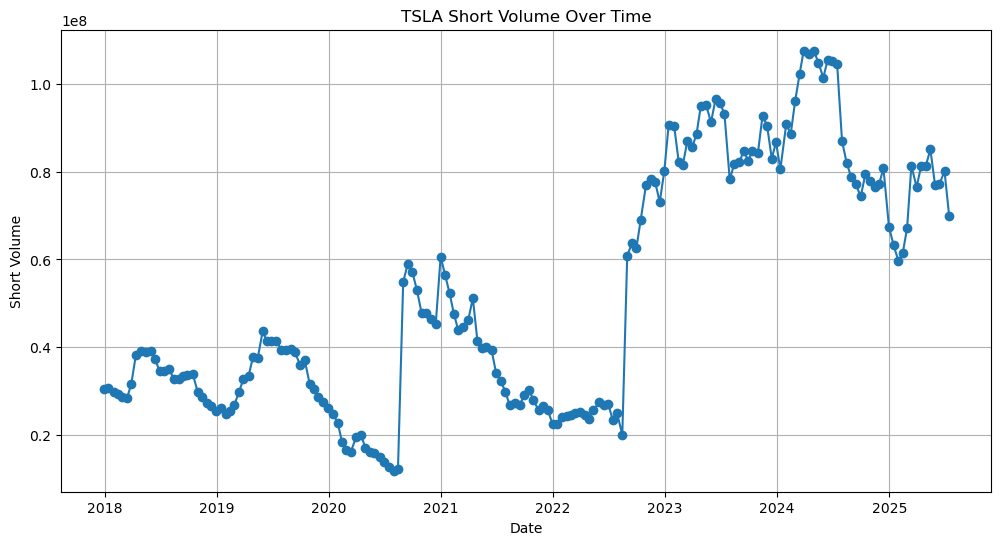

In [2]:
import glob
import matplotlib.pyplot as plt

# Load all FINRA clean files
files = sorted(glob.glob('../data/finra_clean/shrt*_clean.csv'))

# Collect TSLA data from all files
dfs = []
for f in files:
    df = pd.read_csv(f)
    if 'symbolCode' in df.columns:
        tsla_rows = df[df['symbolCode'].str.upper() == 'TSLA'].copy()  # Use .copy() to avoid SettingWithCopyWarning
        if not tsla_rows.empty:
            tsla_rows.loc[:, 'date'] = f.split('shrt')[1].split('_')[0]  # Assign using .loc to avoid warning
            dfs.append(tsla_rows)

if dfs:
    tsla_df = pd.concat(dfs, ignore_index=True)
    tsla_df['date'] = pd.to_datetime(tsla_df['date'], errors='coerce')
    tsla_df = tsla_df.sort_values('date')

    # Plot a relevant time series, e.g., 'Short Volume'
    plt.figure(figsize=(12,6))
    plt.plot(tsla_df['date'], tsla_df['currentShortPositionQuantity'], marker='o')
    plt.title('TSLA Short Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Short Volume')
    plt.grid(True)
    plt.show()
else:
    print('No TSLA data found in the provided files.')

In [7]:
from tqdm import tqdm

# Dictionary to hold time series for each ticker
ticker_timeseries = {}

for idx, f in enumerate(tqdm(files, desc="Processing files")):
    df = pd.read_csv(f)
    date_str = f.split('shrt')[1].split('_')[0]
    for _, row in df.iterrows():
        ticker = row['symbolCode']
        if pd.isnull(ticker):
            continue
        ticker = str(ticker).strip().upper()
        if not ticker:
            continue
        if ticker not in ticker_timeseries:
            ticker_timeseries[ticker] = {'dates': [], 'short_interest': [], 'volume': []}
        ticker_timeseries[ticker]['dates'].append(date_str)
        ticker_timeseries[ticker]['short_interest'].append(row.get('currentShortPositionQuantity', None))
        ticker_timeseries[ticker]['volume'].append(row.get('averageDailyVolumeQuantity', None))

# Convert to DataFrame and add start/end dates
for ticker, d in ticker_timeseries.items():
    ts_df = pd.DataFrame({'date': pd.to_datetime(d['dates'], errors='coerce'), 'short_interest': d['short_interest'], 'volume': d['volume']})
    ts_df = ts_df.sort_values('date')
    ticker_timeseries[ticker] = {
        'startdate': ts_df['date'].min(),
        'enddate': ts_df['date'].max(),
        'SI': ts_df.set_index('date')['short_interest'],
        'Volume': ts_df.set_index('date')['volume']
    }

import pickle

with open("cache/ticker_timeseries.pkl", "wb") as f:
    pickle.dump(ticker_timeseries, f)

Processing files: 100%|██████████| 182/182 [01:40<00:00,  1.81it/s]



In [3]:
import pickle
ticker_timeseries = pickle.load(open("cache/ticker_timeseries.pkl", "rb"))

In [6]:
ticker_timeseries['PFE']

{'startdate': Timestamp('2017-12-29 00:00:00'),
 'enddate': Timestamp('2025-07-15 00:00:00'),
 'SI': date
 2017-12-29     49905703
 2018-01-12     52176014
 2018-01-31     56963145
 2018-02-15     64127631
 2018-02-28     61827751
                 ...    
 2025-05-15    107376473
 2025-05-30    104993610
 2025-06-13    106732210
 2025-06-30    111909372
 2025-07-15     99269883
 Name: short_interest, Length: 182, dtype: int64,
 'Volume': date
 2017-12-29    11834320
 2018-01-12    15643754
 2018-01-31    28232327
 2018-02-15    33450963
 2018-02-28    23715494
                 ...   
 2025-05-15    51202695
 2025-05-30    39906213
 2025-06-13    36683156
 2025-06-30    38374682
 2025-07-15    40242015
 Name: volume, Length: 182, dtype: int64}

Short interest data for OGN is not aligned with PFE.
Short interest data for VTRS is not aligned with PFE.


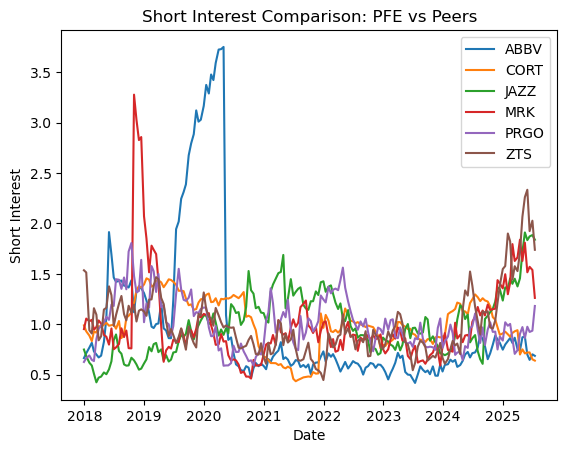

In [24]:
main_stock = 'PFE'
similar_stocks = peers_same_sector_and_subindustry(main_stock)

for stock in similar_stocks:
    if stock == 'LLY' or stock == 'JNJ' :#or stock == 'MRK' or stock == 'ABBV':
        continue
    if ticker_timeseries[stock]['SI'].shape[0] != ticker_timeseries[main_stock]['SI'].shape[0]:
        print(f"Short interest data for {stock} is not aligned with {main_stock}.")
    else:
        plt.plot(ticker_timeseries[stock]['SI'].index, ticker_timeseries[stock]['SI']/ticker_timeseries[stock]['SI'].mean(), label=stock)

# plt.plot(ticker_timeseries[main_stock]['SI'].index, ticker_timeseries[main_stock]['SI']/ticker_timeseries[main_stock]['SI'].mean(), label=main_stock, color='black', linewidth=2)
plt.title(f"Short Interest Comparison: {main_stock} vs Peers")
plt.xlabel("Date")
plt.ylabel("Short Interest")
plt.legend()
plt.show()

Short interest data for OGN is not aligned with PFE.
Short interest data for VTRS is not aligned with PFE.


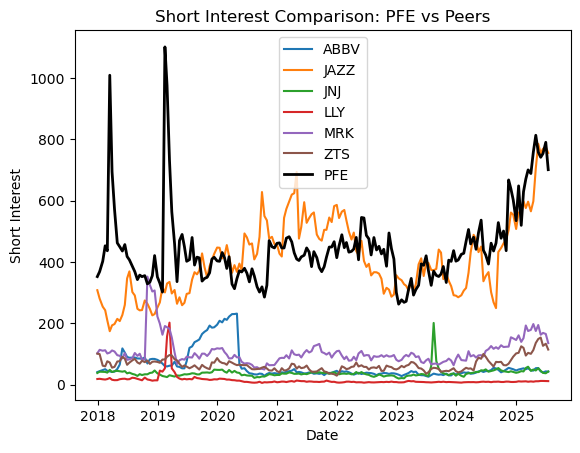

In [18]:
main_stock = 'PFE'
similar_stocks = peers_same_sector_and_subindustry(main_stock)

for stock in similar_stocks:
    if stock == 'CORT' or stock == 'PRGO':
        continue
    market_cap = client.get_ticker_details(stock).market_cap
    if ticker_timeseries[stock]['SI'].shape[0] != ticker_timeseries[main_stock]['SI'].shape[0]:
        print(f"Short interest data for {stock} is not aligned with {main_stock}.")
    else:
        plt.plot(ticker_timeseries[stock]['SI'].index, ticker_timeseries[stock]['SI']/(market_cap/1e6), label=stock)

market_cap = client.get_ticker_details(main_stock).market_cap
plt.plot(ticker_timeseries[main_stock]['SI'].index, ticker_timeseries[main_stock]['SI']/(market_cap/1e6), label=main_stock, color='black', linewidth=2)
plt.title(f"Short Interest Comparison: {main_stock} vs Peers")
plt.xlabel("Date")
plt.ylabel("Short Interest")
plt.legend()
plt.show()

Short interest data for OGN is not aligned with PFE.
Short interest data for VTRS is not aligned with PFE.


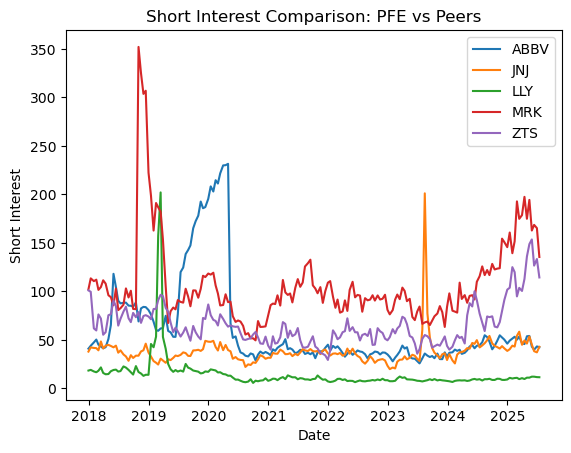

In [19]:
main_stock = 'PFE'
similar_stocks = peers_same_sector_and_subindustry(main_stock)

for stock in similar_stocks:
    if stock == 'CORT' or stock == 'PRGO' or stock == 'JAZZ':
        continue
    market_cap = client.get_ticker_details(stock).market_cap
    if ticker_timeseries[stock]['SI'].shape[0] != ticker_timeseries[main_stock]['SI'].shape[0]:
        print(f"Short interest data for {stock} is not aligned with {main_stock}.")
    else:
        plt.plot(ticker_timeseries[stock]['SI'].index, ticker_timeseries[stock]['SI']/(market_cap/1e6), label=stock)

# market_cap = client.get_ticker_details(main_stock).market_cap
# plt.plot(ticker_timeseries[main_stock]['SI'].index, ticker_timeseries[main_stock]['SI']/(market_cap/1e6), label=main_stock, color='black', linewidth=2)
plt.title(f"Short Interest Comparison: {main_stock} vs Peers")
plt.xlabel("Date")
plt.ylabel("Short Interest")
plt.legend()
plt.show()

In [28]:
import torch
import torch.nn as nn

class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMTimeSeries, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Example usage:
# model = LSTMTimeSeries(input_size=1, hidden_size=50, num_layers=2, output_size=1)


In [113]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Set lookback window
lookback_window = 16

# Select a stock (e.g., TSLA) and get its short interest time series
stock = 'PFE'
series = ticker_timeseries[stock]['SI'].dropna().values.reshape(-1, 1)

# Prepare sequences for LSTM
def create_sequences(data, lookback):
    xs, ys = [], []
    for i in range(len(data) - lookback):
        x = data[i:(i + lookback)]
        y = data[i + lookback]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(series, lookback_window)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Fit scaler only on training data and transform
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, 1)
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Convert to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader
batch_size = 8
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [114]:
# Training

# Initialize model, loss, optimizer
model = LSTMTimeSeries(input_size=1, hidden_size=16, num_layers=2, output_size=1)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 60
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")



Epoch 1/60, Train Loss: 0.908690
Epoch 2/60, Train Loss: 0.894808
Epoch 3/60, Train Loss: 0.880251
Epoch 4/60, Train Loss: 0.870670
Epoch 5/60, Train Loss: 0.862355
Epoch 6/60, Train Loss: 0.852976
Epoch 7/60, Train Loss: 0.843381
Epoch 8/60, Train Loss: 0.828166
Epoch 9/60, Train Loss: 0.818041
Epoch 10/60, Train Loss: 0.801868
Epoch 11/60, Train Loss: 0.796274
Epoch 12/60, Train Loss: 0.790305
Epoch 13/60, Train Loss: 0.756263
Epoch 14/60, Train Loss: 0.754489
Epoch 15/60, Train Loss: 0.737627
Epoch 16/60, Train Loss: 0.717577
Epoch 17/60, Train Loss: 0.709217
Epoch 18/60, Train Loss: 0.712702
Epoch 19/60, Train Loss: 0.683283
Epoch 20/60, Train Loss: 0.669094
Epoch 21/60, Train Loss: 0.649938
Epoch 22/60, Train Loss: 0.661073
Epoch 23/60, Train Loss: 0.652602
Epoch 24/60, Train Loss: 0.667231
Epoch 25/60, Train Loss: 0.635470
Epoch 26/60, Train Loss: 0.615004
Epoch 27/60, Train Loss: 0.666186
Epoch 28/60, Train Loss: 0.625340
Epoch 29/60, Train Loss: 0.617091
Epoch 30/60, Train Loss

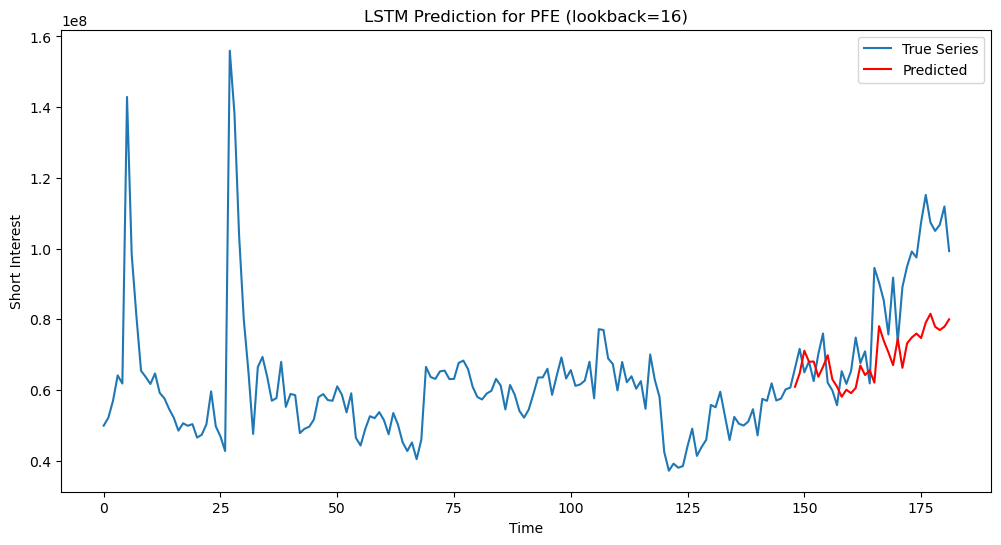

In [115]:
# Evaluation
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        out = model(xb)
        preds.append(out.numpy())
        # print(xb)
        # print(out.numpy())
preds = np.concatenate(preds, axis=0)

# Inverse transform predictions and targets
preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(12,6))
# plt.plot(range(split+lookback_window, split+lookback_window+len(y_test_scaled)), y_test_scaled, label='True (scaled)', color='blue')
# plt.plot(range(split+lookback_window, split+lookback_window+len(preds)), preds, label='Predicted', color='red')

plt.plot(range(len(series)), series, label='True Series')
plt.plot(range(split+lookback_window, split+lookback_window+len(preds)), preds_inv, label='Predicted', color='red')

plt.title(f'LSTM Prediction for {stock} (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

d:\software\anaconda3\envs\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


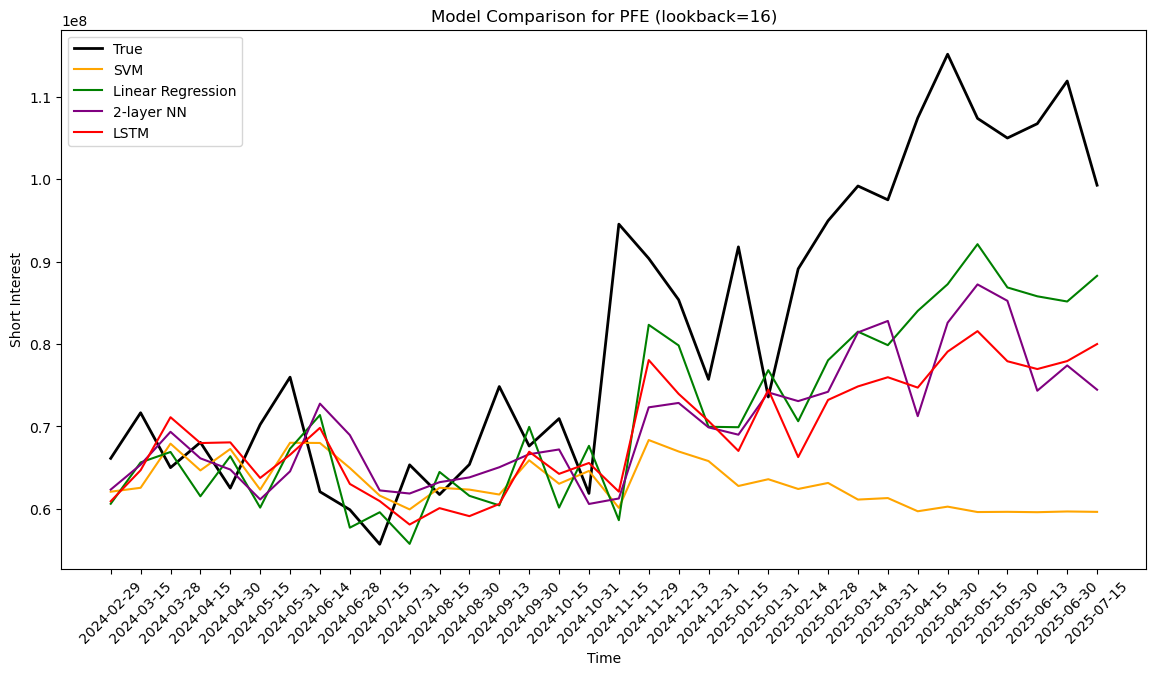

In [116]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Use the same data as LSTM (flattened for sklearn models)
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# SVM
svm = SVR()
svm.fit(X_train_flat, y_train_scaled.ravel())
svm_preds = svm.predict(X_test_flat)
svm_preds_inv = scaler.inverse_transform(svm_preds.reshape(-1, 1))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_flat, y_train_scaled.ravel())
lr_preds = lr.predict(X_test_flat)
lr_preds_inv = scaler.inverse_transform(lr_preds.reshape(-1, 1))

# 2-layer Neural Network (MLP)
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42)
mlp.fit(X_train_flat, y_train_scaled.ravel())
mlp_preds = mlp.predict(X_test_flat)
mlp_preds_inv = scaler.inverse_transform(mlp_preds.reshape(-1, 1))

# Plot all predictions
plt.figure(figsize=(14,7))
# plt.plot(range(len(series)), series, label='True Series')
# plt.plot(range(split+lookback_window, split+lookback_window+len(preds_inv)), preds_inv, label='LSTM', color='red')
# plt.plot(range(split+lookback_window, split+lookback_window+len(svm_preds_inv)), svm_preds_inv, label='SVM', color='orange')
# plt.plot(range(split+lookback_window, split+lookback_window+len(lr_preds_inv)), lr_preds_inv, label='Linear Regression', color='green')
# plt.plot(range(split+lookback_window, split+lookback_window+len(mlp_preds_inv)), mlp_preds_inv, label='2-layer NN', color='purple')
plt.plot(range(split+lookback_window, split+lookback_window+len(y_test)), y_test, label='True', color='black', linewidth=2)
plt.plot(range(split+lookback_window, split+lookback_window+len(svm_preds_inv)), svm_preds_inv, label='SVM', color='orange')
plt.plot(range(split+lookback_window, split+lookback_window+len(lr_preds_inv)), lr_preds_inv, label='Linear Regression', color='green')
plt.plot(range(split+lookback_window, split+lookback_window+len(mlp_preds_inv)), mlp_preds_inv, label='2-layer NN', color='purple')
plt.plot(range(split+lookback_window, split+lookback_window+len(preds_inv)), preds_inv, label='LSTM', color='red')
# Set x-ticks to be the dates from tsla_df['date'] for the test period
test_dates = tsla_df['date'].iloc[split+lookback_window:split+lookback_window+len(y_test)]
plt.xticks(ticks=range(split+lookback_window, split+lookback_window+len(y_test)), labels=test_dates.dt.strftime('%Y-%m-%d'), rotation=45)
plt.title(f'Model Comparison for {stock} (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

In [ ]:
# Standard Scaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd

# True values (scaled)
y_true = y_test.flatten()

# LSTM predictions (scaled)
lstm_pred = scaler.inverse_transform(preds).flatten()

# SVM, LR, MLP predictions (scaled)
svm_pred = scaler.inverse_transform(svm_preds.reshape(-1, 1)).flatten()
lr_pred = scaler.inverse_transform(lr_preds.reshape(-1, 1)).flatten()
mlp_pred = scaler.inverse_transform(mlp_preds.reshape(-1, 1)).flatten()


# Calculate metrics
def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

results = []
for name, pred in [
    ("LSTM", lstm_pred),
    ("SVM", svm_pred),
    ("Linear Regression", lr_pred),
    ("2-layer NN", mlp_pred)
]:
    mape, rmse = get_metrics(y_true, pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

            Model     MAPE         RMSE
             LSTM 0.154194 1.793787e+07
              SVM 0.213611 2.675283e+07
Linear Regression 0.133804 1.456619e+07
       2-layer NN 0.145157 1.719507e+07


In [ ]:
# MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd

# True values (scaled)
y_true = y_test.flatten()

# LSTM predictions (scaled)
lstm_pred = scaler.inverse_transform(preds).flatten()

# SVM, LR, MLP predictions (scaled)
svm_pred = scaler.inverse_transform(svm_preds.reshape(-1, 1)).flatten()
lr_pred = scaler.inverse_transform(lr_preds.reshape(-1, 1)).flatten()
mlp_pred = scaler.inverse_transform(mlp_preds.reshape(-1, 1)).flatten()


# Calculate metrics
def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

results = []
for name, pred in [
    ("LSTM", lstm_pred),
    ("SVM", svm_pred),
    ("Linear Regression", lr_pred),
    ("2-layer NN", mlp_pred)
]:
    mape, rmse = get_metrics(y_true, pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

            Model     MAPE         RMSE
             LSTM 0.201316 2.321666e+07
              SVM 0.147848 1.812146e+07
Linear Regression 0.122303 1.380336e+07
       2-layer NN 0.169979 2.041206e+07


# Multi-stocks

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


Epoch 1/200, Train Loss: 0.852650
Epoch 11/200, Train Loss: 0.612216
Epoch 21/200, Train Loss: 0.477591
Epoch 31/200, Train Loss: 0.381863
Epoch 41/200, Train Loss: 0.496277
Epoch 51/200, Train Loss: 0.276529
Epoch 61/200, Train Loss: 0.268981
Epoch 71/200, Train Loss: 0.204033
Epoch 81/200, Train Loss: 0.250963
Epoch 91/200, Train Loss: 0.140631
Epoch 101/200, Train Loss: 0.145105
Epoch 111/200, Train Loss: 0.110896
Epoch 121/200, Train Loss: 0.108907
Epoch 131/200, Train Loss: 0.110719
Epoch 141/200, Train Loss: 0.098971
Epoch 151/200, Train Loss: 0.095542
Epoch 161/200, Train Loss: 0.083648
Epoch 171/200, Train Loss: 0.327247
Epoch 181/200, Train Loss: 0.096723
Epoch 191/200, Train Loss: 0.082025


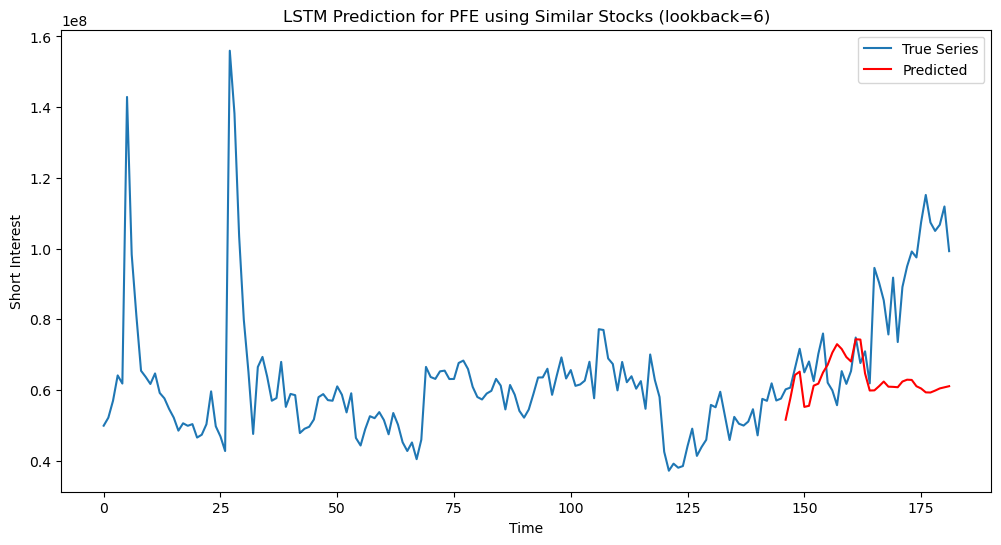

In [131]:
lookback_window = 6

# Prepare multi-stock input for LSTM: main stock + similar stocks (each normalized separately)
main_stock = 'PFE'
# similar_stocks = peers_same_sector_and_subindustry(main_stock)
similar_stocks = ['MRK', 'JAZZ', 'ZTS']  # Manually selected for demo

# Collect all series (main + similar), align by date
all_stocks = [main_stock] + similar_stocks
aligned_dates = ticker_timeseries[main_stock]['SI'].index
stock_series = {}
scalers = {}
for stock in all_stocks:
    # Align to main stock's dates, fill missing with nan
    s = ticker_timeseries[stock]['SI'].reindex(aligned_dates).values.reshape(-1, 1)
    scaler = StandardScaler()
    # Fit scaler only on training portion for each stock
    split = int(0.8 * (len(s) - lookback_window))
    scaler.fit(s[:split+lookback_window][~np.isnan(s[:split+lookback_window])].reshape(-1, 1))
    s_scaled = scaler.transform(np.nan_to_num(s, nan=0.0))
    stock_series[stock] = s_scaled
    scalers[stock] = scaler

# Stack all features: shape (n_samples, n_stocks)
features = np.hstack([stock_series[stock] for stock in all_stocks])

# Prepare sequences for LSTM (multi-feature)
def create_multi_sequences(data, target, lookback):
    xs, ys = [], []
    for i in range(len(data) - lookback):
        x = data[i:(i + lookback), :]
        y = target[i + lookback]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

target_series = stock_series[main_stock]
X_multi, y_multi = create_multi_sequences(features, target_series, lookback_window)

# Split into train/test
split = int(0.8 * len(X_multi))
X_train, X_test = X_multi[:split], X_multi[split:]
y_train, y_test = y_multi[:split], y_multi[split:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
batch_size = 8
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model: input_size = number of stocks
model = LSTMTimeSeries(input_size=len(all_stocks), hidden_size=16, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (short for demo)
epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

# Evaluation
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        out = model(xb)
        preds.append(out.numpy())
preds = np.concatenate(preds, axis=0)

# Inverse transform predictions (main stock scaler)
preds_inv = scalers[main_stock].inverse_transform(preds)
y_test_inv = scalers[main_stock].inverse_transform(y_test)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(range(len(aligned_dates)), ticker_timeseries[main_stock]['SI'].values, label='True Series')
plt.plot(range(split+lookback_window, split+lookback_window+len(preds_inv)), preds_inv, label='Predicted', color='red')
plt.title(f'LSTM Prediction for {main_stock} using Similar Stocks (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

d:\software\anaconda3\envs\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


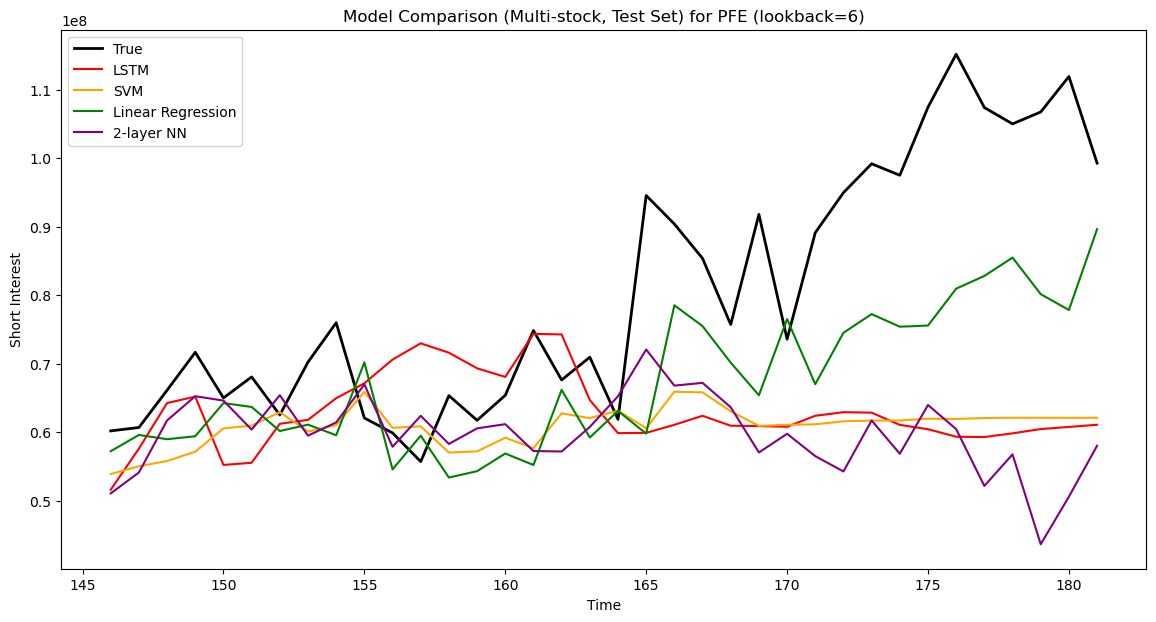

            Model     MAPE         RMSE
             LSTM 0.225161 2.656714e+07
              SVM 0.218932 2.581279e+07
Linear Regression 0.155052 1.723006e+07
       2-layer NN 0.232542 2.870811e+07


In [133]:

# Use the same data as LSTM (multi-stock, flattened for sklearn models)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# SVM
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_preds = svm.predict(X_test_flat)
svm_preds_inv = scalers[main_stock].inverse_transform(svm_preds.reshape(-1, 1))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_preds = lr.predict(X_test_flat)
lr_preds_inv = scalers[main_stock].inverse_transform(lr_preds.reshape(-1, 1))

# 2-layer Neural Network (MLP)
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=200, random_state=42)
mlp.fit(X_train_flat, y_train.ravel())
mlp_preds = mlp.predict(X_test_flat)
mlp_preds_inv = scalers[main_stock].inverse_transform(mlp_preds.reshape(-1, 1))

# Plot only the test set predictions
plt.figure(figsize=(14,7))
test_idx = range(split+lookback_window, split+lookback_window+len(y_test))
plt.plot(test_idx, scalers[main_stock].inverse_transform(y_test), label='True', color='black', linewidth=2)
plt.plot(test_idx, preds_inv, label='LSTM', color='red')
plt.plot(test_idx, svm_preds_inv, label='SVM', color='orange')
plt.plot(test_idx, lr_preds_inv, label='Linear Regression', color='green')
plt.plot(test_idx, mlp_preds_inv, label='2-layer NN', color='purple')
plt.title(f'Model Comparison (Multi-stock, Test Set) for {main_stock} (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

# Metrics
def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

results = []
for name, pred in [
    ("LSTM", preds_inv.flatten()),
    ("SVM", svm_preds_inv.flatten()),
    ("Linear Regression", lr_preds_inv.flatten()),
    ("2-layer NN", mlp_preds_inv.flatten())
]:
    mape, rmse = get_metrics(y_test_inv.flatten(), pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Predict Difference

## Single Stock

Epoch 1/60, Train Loss: 0.016381
Epoch 11/60, Train Loss: 0.011191
Epoch 21/60, Train Loss: 0.010902
Epoch 31/60, Train Loss: 0.010357
Epoch 41/60, Train Loss: 0.009983
Epoch 51/60, Train Loss: 0.009959


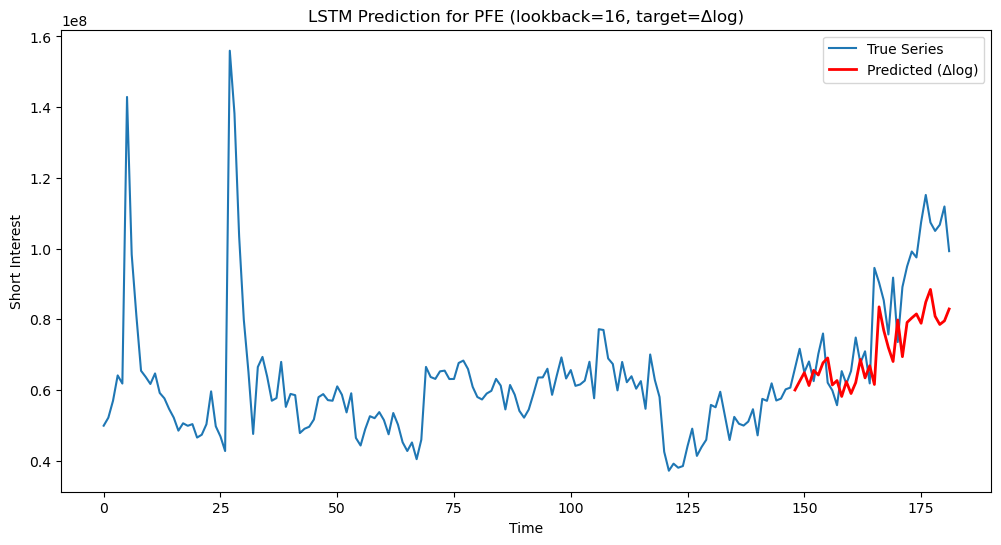

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

# ---------- params ----------
lookback_window = 16
stock = 'PFE'
eps = 1e-8  # to avoid log(0)

# ---------- data ----------
# raw levels (T, 1)
series = ticker_timeseries[stock]['SI'].dropna().values.astype(np.float64).reshape(-1, 1)

# log of levels (T,) for the target
series_safe = np.where(series <= 0, eps, series).reshape(-1)
y_log = np.log(series_safe)

# build supervised windows with log-return target
# r_t = log(y_t) - log(y_{t-1}); keep previous log level to reconstruct
def make_windows_level_to_logret(level_series, y_log, lookback):
    X_list, y_logret_list, prev_log_list = [], [], []
    for t in range(lookback, len(level_series)):
        X_list.append(level_series[t - lookback:t, :])                  # (L, 1)
        y_logret_list.append([y_log[t] - y_log[t - 1]])                 # (1,)
        prev_log_list.append(y_log[t - 1])                               # scalar
    X = np.asarray(X_list)                          # (N, L, 1)
    y_logret = np.asarray(y_logret_list)            # (N, 1)
    prev_log = np.asarray(prev_log_list)            # (N,)
    return X, y_logret, prev_log

X_raw, y_logret, prev_log_all = make_windows_level_to_logret(series, y_log, lookback_window)

# ---------- split ----------
N = X_raw.shape[0]
split = int(0.8 * N)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
scaler = StandardScaler().fit(X_train_raw.reshape(-1, 1))
X_train = scaler.transform(X_train_raw.reshape(-1, 1)).reshape(X_train_raw.shape)
X_test  = scaler.transform(X_test_raw.reshape(-1, 1)).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- model (predicts log-return) ----------
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # output: Δlog
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = LSTMTimeSeries(input_size=1, hidden_size=32, num_layers=2, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------- training ----------
epochs = 60
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---------- plot ----------
plt.figure(figsize=(12, 6))
plt.plot(range(len(series)), series.reshape(-1), label='True Series', linewidth=1.5)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (Δlog)', color='red', linewidth=2)
plt.title(f'LSTM Prediction for {stock} (lookback={lookback_window}, target=Δlog)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()


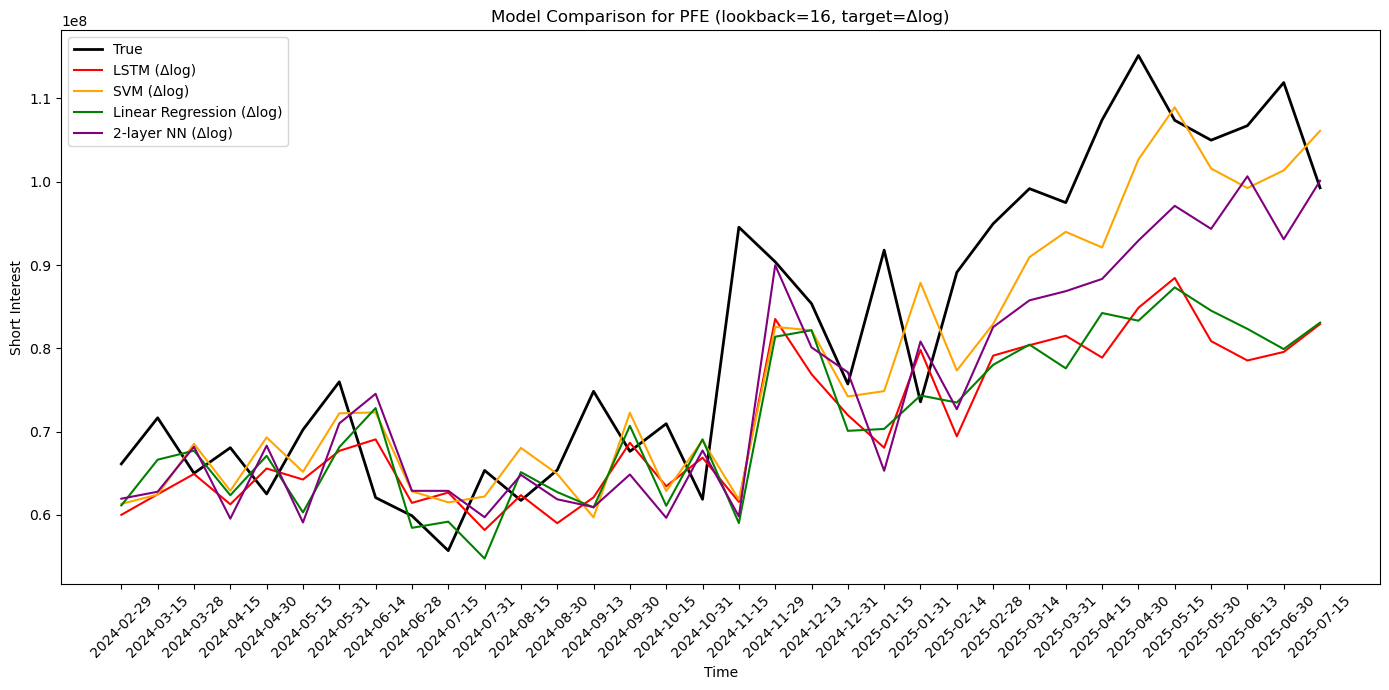

            Model     MAPE         RMSE
             LSTM 0.139096 1.587733e+07
              SVM 0.097486 1.002043e+07
Linear Regression 0.138935 1.559129e+07
       2-layer NN 0.115533 1.233101e+07


In [16]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (L,1) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# series                         # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------

# flatten inputs for sklearn
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# ---- SVM predicts Δlog ----
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
import torch.nn as nn

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()

# Predict
mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = ticker_timeseries[stock]['SI'].dropna().index  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')
plt.xticks(
    ticks=test_idx,
    labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
    rotation=45
)
plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

results = []
for name, pred in [
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


## Multi Stock

Epoch 1/200, Train Loss: 0.016303
Epoch 11/200, Train Loss: 0.010178
Epoch 21/200, Train Loss: 0.009259
Epoch 31/200, Train Loss: 0.007507
Epoch 41/200, Train Loss: 0.005310
Epoch 51/200, Train Loss: 0.004486
Epoch 61/200, Train Loss: 0.004227
Epoch 71/200, Train Loss: 0.003836
Epoch 81/200, Train Loss: 0.003679
Epoch 91/200, Train Loss: 0.003472
Epoch 101/200, Train Loss: 0.003571
Epoch 111/200, Train Loss: 0.003667
Epoch 121/200, Train Loss: 0.003174
Epoch 131/200, Train Loss: 0.002800
Epoch 141/200, Train Loss: 0.002443
Epoch 151/200, Train Loss: 0.002840
Epoch 161/200, Train Loss: 0.001887
Epoch 171/200, Train Loss: 0.001445
Epoch 181/200, Train Loss: 0.001201
Epoch 191/200, Train Loss: 0.001121


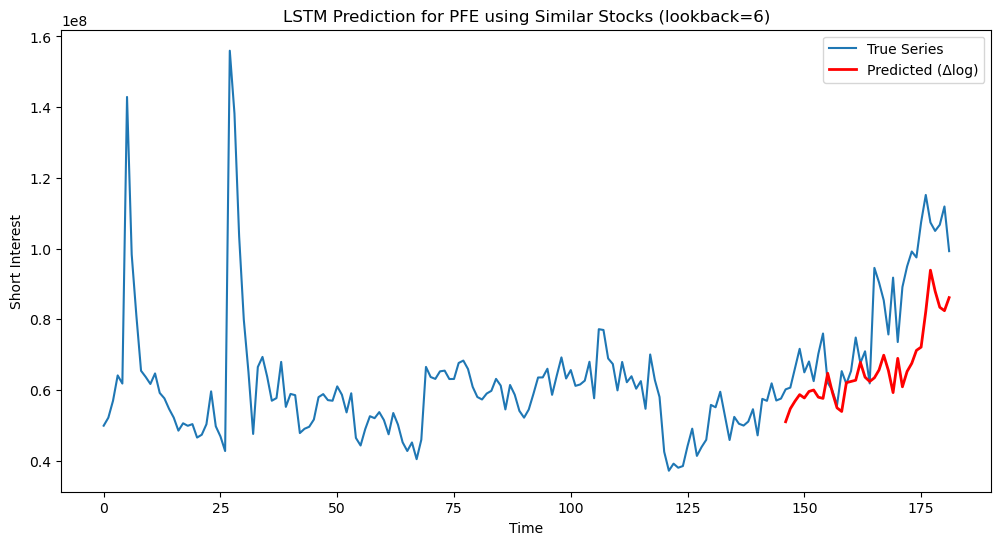

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ---------- params ----------
lookback_window = 6
main_stock = 'PFE'
similar_stocks = ['MRK', 'JAZZ', 'ZTS']  # demo
all_stocks = [main_stock] + similar_stocks
eps = 1e-8  # for safe logs

# ---------- collect & scale inputs (per stock, fit on train only) ----------
aligned_dates = ticker_timeseries[main_stock]['SI'].index
stock_series = {}
scalers = {}

# determine split index in *sequence* space
T = len(aligned_dates)
seq_split_idx = int(0.8 * (T - lookback_window))   # sequences count split

for stock in all_stocks:
    s_raw = ticker_timeseries[stock]['SI'].reindex(aligned_dates).values.astype(np.float64).reshape(-1, 1)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # fit on the portion that will end up forming training sequences
    fit_upto = seq_split_idx + lookback_window
    s_fit = s_raw[:fit_upto]
    scaler.fit(s_fit[~np.isnan(s_fit)].reshape(-1, 1))
    s_scaled = scaler.transform(np.nan_to_num(s_raw, nan=0.0))
    stock_series[stock] = s_scaled
    scalers[stock] = scaler

# stack features: (T, n_stocks)
features = np.hstack([stock_series[s] for s in all_stocks])  # scaled inputs

# ---------- build target as log-return of main stock ----------
# we use the *unscaled* main series for the target
y_main_raw = ticker_timeseries[main_stock]['SI'].reindex(aligned_dates).values.astype(np.float64)
y_main_raw = np.where(y_main_raw <= 0, eps, y_main_raw)  # avoid log(0)
y_log = np.log(y_main_raw)

def create_multi_sequences_with_logret(X_all, y_log, lookback):
    xs, y_ret, prev_log = [], [], []
    for i in range(lookback, len(X_all)):
        # input window
        xs.append(X_all[i - lookback:i, :])
        # log-return target r_t = log y_t - log y_{t-1}
        r_t = y_log[i] - y_log[i - 1]
        y_ret.append([r_t])
        prev_log.append(y_log[i - 1])  # to reconstruct level later
    return np.asarray(xs), np.asarray(y_ret), np.asarray(prev_log)

X_multi, y_logret, prev_log_all = create_multi_sequences_with_logret(features, y_log, lookback_window)

# ---------- split train/test ----------
split = seq_split_idx
X_train, X_test = X_multi[:split], X_multi[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- model ----------
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # predict log-return
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]          # last timestep
        out = self.fc(out)           # (batch, 1)
        return out

model = LSTMTimeSeries(input_size=len(all_stocks), hidden_size=32, num_layers=2, output_size=1)
criterion = nn.SmoothL1Loss()  # Huber; more robust than MSE for tails
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------- training ----------
epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret_list = []
with torch.no_grad():
    for xb, _ in test_loader:
        out = model(xb)              # predicted r_t
        pred_logret_list.append(out.numpy())
pred_logret = np.concatenate(pred_logret_list, axis=0).ravel()

# reconstruct: y_hat_t = exp(prev_log_t + r_hat_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# (optional) true levels aligned to y_pred (these are y_t for the test sequences)
y_true_levels = np.exp(prev_log_test + y_test.ravel())  # or simply np.exp(y_log[lookback_window+split:])

# ---------- plot ----------
plt.figure(figsize=(12,6))
plt.plot(range(len(aligned_dates)), y_main_raw, label='True Series', linewidth=1.5)
start_idx = split + lookback_window
end_idx = start_idx + len(y_pred_levels)
plt.plot(range(start_idx, end_idx), y_pred_levels, label='Predicted (Δlog)', color='red', linewidth=2)
plt.title(f'LSTM Prediction for {main_stock} using Similar Stocks (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()


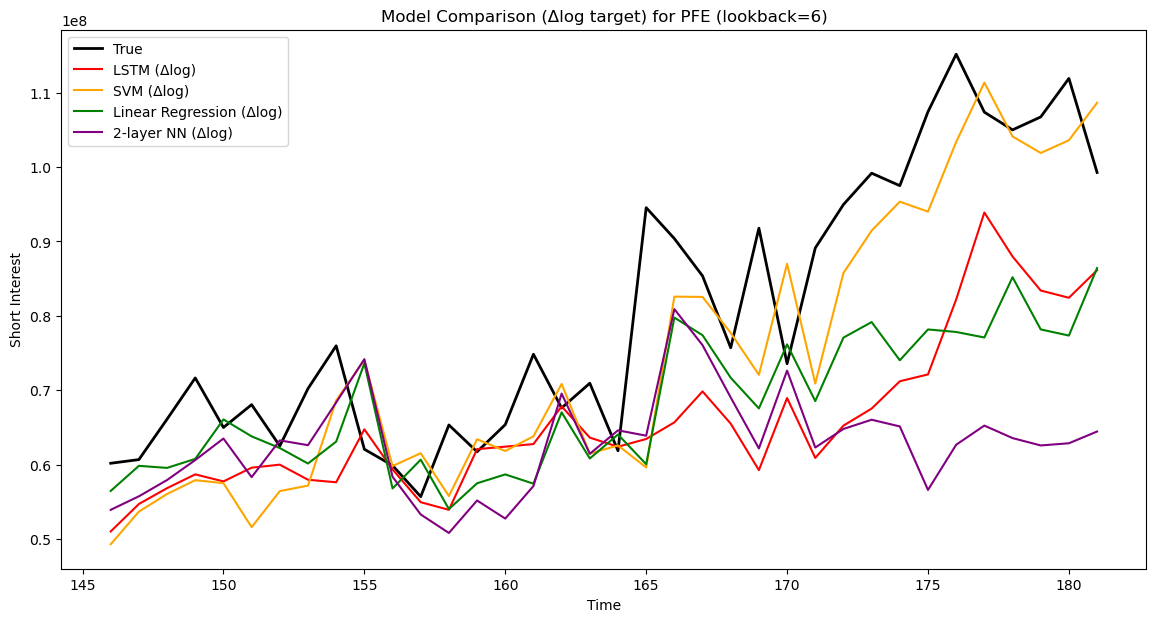

            Model     MAPE         RMSE
             LSTM 0.163945 1.833297e+07
              SVM 0.112338 1.106785e+07
Linear Regression 0.149328 1.718717e+07
       2-layer NN 0.201170 2.452591e+07


In [19]:
# ----------------------
# Flatten inputs for sklearn models (same X used by LSTM)
# X_train, X_test, y_train, y_test are log-return targets from the new pipeline
# prev_log_test is the vector of log y_{t-1} for each test sample
# ----------------------
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# ---------- SVM on log-returns ----------
from sklearn.svm import SVR
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret = svm.predict(X_test_flat)                     # r̂_t
svm_levels = np.exp(prev_log_test + svm_logret)           # ŷ_t

# ---------- Linear Regression on log-returns ----------
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret = lr.predict(X_test_flat)
lr_levels = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
import torch.nn as nn

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()

# Predict
mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---------- LSTM outputs ----------
# If your LSTM block produced `pred_logret` (shape [n_test,]) previously:
# y_pred_levels = np.exp(prev_log_test + pred_logret)
lstm_levels = y_pred_levels  # rename for consistency

# ---------- True levels aligned with targets ----------
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---------- Plot (test window only) ----------
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')
plt.title(f'Model Comparison (Δlog target) for {main_stock} (lookback={lookback_window})')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.show()

# ---------- Metrics in ORIGINAL LEVEL units ----------
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import numpy as np

def get_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE
    return mape, rmse

results = []
for name, pred in [
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAPE": mape, "RMSE": rmse})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
